## Data files 

mofid_test.cvs/.json - normalized dictionary of MOFid

test.csv/.json - normalized all data (mofid, mofkey, space group, cell parameter, organic linker, metal node and etc.)

func.py - script for normalization raw data 

In [77]:
import pandas as pd 

# Import comet_ml at the top of your file
# from comet_ml import Experiment

import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Data preparing 

In [78]:
# Import the dataset and split it into train and test
data = pd.read_csv('03_04_prepare.csv', index_col=0)
train_dataset, test_dataset = train_test_split(data, test_size=0.2)


In [79]:
train_dataset

,simples_nodes,simples_linkers,simples,topology,cat,a,b,c,alpha,beta,gamma,cell volume,space group
cifname,,,,,,,,,,,,,
7125728,0.907990,0.886047,0.885537,0.144796,0.000000,0.053186,0.061045,0.049529,0.935040,0.503280,0.771974,0.000335,0.060976
7045284,0.145278,0.748837,0.748004,0.058824,0.142857,0.072174,0.137345,0.103386,0.370585,0.335918,0.385969,0.002728,0.060976
4333577,0.106538,0.019767,0.461402,0.565611,0.000000,0.314298,0.314446,0.241998,0.515868,0.354983,0.480222,0.039471,0.250000
7036839,0.089588,0.722093,0.705413,0.122172,0.285714,0.176777,0.176956,0.309351,0.515868,0.354983,1.000000,0.015718,0.390244
7033251,0.266344,0.708140,0.692103,0.447964,0.142857,0.146705,0.129984,0.049158,0.515868,0.750487,0.480222,0.002324,0.085366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106356,0.024213,0.398837,0.803904,0.502262,0.000000,0.043874,0.258304,0.245601,0.515868,0.445486,0.480222,0.007685,0.085366
4111647,0.106538,0.194186,0.167702,0.266968,0.142857,0.220834,0.221003,0.168848,0.515868,0.354983,0.480222,0.015561,0.420732
4518504,0.648910,0.643023,0.625555,0.461538,0.000000,0.330141,0.330286,0.118097,0.515868,0.354983,1.000000,0.020495,0.536585


In [80]:
# Convert the data to tensors
train_dataset = tf.convert_to_tensor(train_dataset.to_numpy())
test_dataset = tf.convert_to_tensor(test_dataset.to_numpy())

## Variational autoencoder

In [83]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(13,)),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout1'),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5, name = 'dropout2'),
            tf.keras.layers.Dense(latent_dim*2),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(13)
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [84]:
# What 
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# Compute loss function (in this case - ELBO)
def compute_loss(model, x):
  # Check input shape
  if len(x.shape) == 1:
    x = tf.expand_dims(x, axis=0)
  
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x = tf.cast(x, dtype=tf.float32)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Compute gradients and update parameters
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  # x = tf.expand_dims(x, axis=1)
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [85]:
# Introduce model and optimizer
latent_dim = 2
epochs = 50
model = CVAE(2)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [86]:
# Define the metrics
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

# Store the losses for each epoch
train_elbo_history = []
test_elbo_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training loop
    for train_x in train_dataset:
        train = tf.expand_dims(train_x, axis=0)
        train_loss = train_step(model, train, optimizer)
        train_loss_metric(train_loss)

    # Evaluation loop
    for test_x in test_dataset:
        test_loss = compute_loss(model, test_x)
        test_loss_metric(test_loss)

    end_time = time.time()
    
    # Calculate the ELBO
    train_elbo = -train_loss_metric.result()
    test_elbo = -test_loss_metric.result()

    # Print results
    print("\n" + "-" * 50)
    print(f'Epoch: {epoch}, Train ELBO: {train_elbo}, Test ELBO: {test_elbo}, time elapsed for current epoch: {end_time - start_time}')

    # Store the losses for each epoch
    train_elbo_history.append(train_elbo)
    test_elbo_history.append(test_elbo)
    
    # Reset metrics at the end of each epoch
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()


--------------------------------------------------
Epoch: 1, Train ELBO: -7.799281120300293, Test ELBO: -7.16105318069458, time elapsed for current epoch: 9.937554836273193

--------------------------------------------------
Epoch: 2, Train ELBO: -6.998828411102295, Test ELBO: -6.898993968963623, time elapsed for current epoch: 7.298125267028809

--------------------------------------------------
Epoch: 3, Train ELBO: -6.90244722366333, Test ELBO: -6.896378517150879, time elapsed for current epoch: 7.240089416503906

--------------------------------------------------
Epoch: 4, Train ELBO: -6.868023872375488, Test ELBO: -6.889008045196533, time elapsed for current epoch: 7.575967073440552

--------------------------------------------------
Epoch: 5, Train ELBO: -6.854156970977783, Test ELBO: -6.858829498291016, time elapsed for current epoch: 7.231169700622559

--------------------------------------------------
Epoch: 6, Train ELBO: -6.84381628036499, Test ELBO: -6.842940807342529, tim

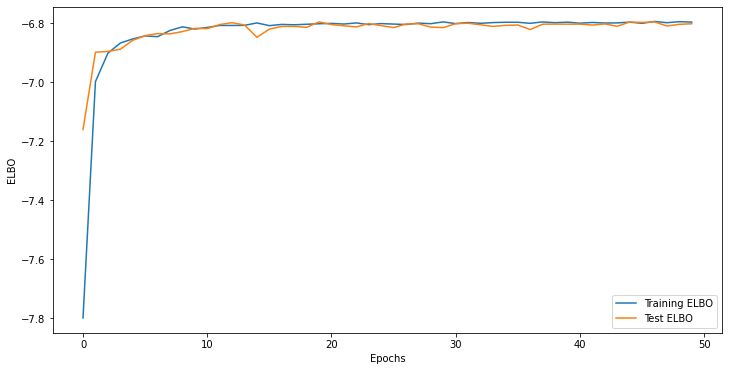

In [88]:
# Plot the ELBO for check overfitting
plt.figure(figsize=(12, 6))
plt.plot(train_elbo_history, label='Training ELBO')
plt.plot(test_elbo_history, label='Test ELBO')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.legend()
plt.show()

In [ ]:
# Grisha, we need to write the encryptor function from the data obtained at the output of the neuron after its training 

In [ ]:
test = 1 